In [1]:
import pandas as pd
import numpy as np

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pickle
import os 
import shutil

# Modelling
Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb

# Preparation

Read in files for direction 1 and 2

In [185]:
df_dir_1 = pd.read_csv('/Users/rebeccadillon/git/dublin-bus-team-5/data/cleaned/feature_pairwise_cleaned_dir1.csv')
df_dir_2 = pd.read_csv('/Users/rebeccadillon/git/dublin-bus-team-5/data/cleaned/feature_pairwise_cleaned_dir2.csv')

Print some descriptors of the data

In [186]:
print("The shape of the direction 1 dataframe is:", df_dir_1.shape)
print("The shape of the direction 2 dataframe is:", df_dir_2.shape)

The shape of the direction 1 dataframe is: (354155, 11)
The shape of the direction 2 dataframe is: (352480, 10)


In [187]:
print("The datatypes in the direction 1 dataframe is:")
print(df_dir_1.dtypes)
print("The datatypes in the direction 2 dataframe is:")
print(df_dir_2.dtypes)

The datatypes in the direction 1 dataframe is:
temp               float64
humidity             int64
wind_speed         float64
weather_id           int64
heavy_precip         int64
HOUR                 int64
LINEID              object
PLANNEDTIME_DEP    float64
TRIPTIME           float64
WEEKDAY              int64
MONTH                int64
dtype: object
The datatypes in the direction 2 dataframe is:
humidity             int64
wind_speed         float64
weather_id           int64
heavy_precip         int64
HOUR                 int64
LINEID              object
PLANNEDTIME_DEP    float64
TRIPTIME           float64
WEEKDAY              int64
MONTH                int64
dtype: object


Check for null values

In [188]:
print("The number of null values in the direction 1 dataframe is: ", str(df_dir_1.isna().sum()))
print("The number of null values in the direction 2 dataframe is: ", str(df_dir_2.isna().sum()))

The number of null values in the direction 1 dataframe is:  temp               0
humidity           0
wind_speed         0
weather_id         0
heavy_precip       0
HOUR               0
LINEID             0
PLANNEDTIME_DEP    0
TRIPTIME           0
WEEKDAY            0
MONTH              0
dtype: int64
The number of null values in the direction 2 dataframe is:  humidity           0
wind_speed         0
weather_id         0
heavy_precip       0
HOUR               0
LINEID             0
PLANNEDTIME_DEP    0
TRIPTIME           0
WEEKDAY            0
MONTH              0
dtype: int64


Viewing the above column names in each dataframe. Column names should be consistent throughout both direction 1 and 2 dataframes. This is to ensure both dataframes contain the same columns for simplicity when combining with the front-end for feature input.

We can see above that direction 1 differs to direction 2 where it has the column temp. I will remove temp from direction 1 so that both dataframes contain the same features. This will make connecting the model with the frontend to fetch the input variables much easier.

In [189]:
df_dir_1 = df_dir_1.drop(columns=['temp'], axis=1)

In [190]:
print("The columns in direction 1 dataframe are:")
print(df_dir_1.columns)

print("The columns in direction 2 dataframe are:")
print(df_dir_2.columns)


The columns in direction 1 dataframe are:
Index(['humidity', 'wind_speed', 'weather_id', 'heavy_precip', 'HOUR',
       'LINEID', 'PLANNEDTIME_DEP', 'TRIPTIME', 'WEEKDAY', 'MONTH'],
      dtype='object')
The columns in direction 2 dataframe are:
Index(['humidity', 'wind_speed', 'weather_id', 'heavy_precip', 'HOUR',
       'LINEID', 'PLANNEDTIME_DEP', 'TRIPTIME', 'WEEKDAY', 'MONTH'],
      dtype='object')


In [191]:
df_dir_1.to_csv('/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/modelling_ready_dir1.csv', index=False)
df_dir_2.to_csv('/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/modelling_ready_dir2.csv', index=False)

# Direction 1
Remembering from <i>s4_feature_pairwise_interactions.ipynb</i> the following:<br>
* Categorical features with medium information gain are 'MONTH', 'heavy_precip' and 'weather_id'
* Categorical features with high information gain are 'HOUR' and 'WEEKDAY'
* Categorical features with low information gain were dropped.
<br>

When tried first on a linear regression model, we were receiving low accuracy with $r^2$ values below 0.2. We then switched to a Random Forest Regressor (RFR) model, which was proving to be a better fit for the data.

We began the RFR with all features (both medium and high information gain), and omitted features step by step in order to find the highest performing model that would give the most accuracy. Below is the code for this model.

## 1.1 Test-train-split

Drop columns negatively impacting the model's performance:

In [2]:
df_dir_1 = pd.read_csv('/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/modelling_ready_dir1.csv')

In [3]:
df_dir_1 = df_dir_1.drop(columns=['heavy_precip','weather_id','HOUR'])
df_dir_1

,humidity,wind_speed,LINEID,PLANNEDTIME_DEP,TRIPTIME,WEEKDAY,MONTH
0,75,5.10,65,19800.0,4425.0,1,1
1,81,3.10,14,23400.0,4281.0,1,1
2,81,3.10,39,22920.0,3758.0,1,1
3,81,3.10,140,24000.0,2732.0,1,1
4,81,3.10,123,24000.0,2658.0,1,1
...,...,...,...,...,...,...,...
354150,79,0.89,25B,78420.0,2559.0,0,12
354151,80,1.79,130,79200.0,1734.0,0,12
354152,80,1.79,27B,78900.0,2108.0,0,12
354153,80,1.79,120,79200.0,1327.0,0,12


Print a list of the unique line ids in the dataframe.

In [4]:
lines_dir_1 = sorted(list(df_dir_1['LINEID'].unique()))
lines_dir_1

['1',
 '102',
 '104',
 '11',
 '111',
 '114',
 '116',
 '120',
 '122',
 '123',
 '13',
 '130',
 '14',
 '140',
 '142',
 '145',
 '14C',
 '15',
 '150',
 '151',
 '15A',
 '15B',
 '15D',
 '16',
 '161',
 '16C',
 '16D',
 '17',
 '17A',
 '18',
 '184',
 '185',
 '220',
 '236',
 '238',
 '239',
 '25',
 '25A',
 '25B',
 '25D',
 '25X',
 '26',
 '27',
 '270',
 '27A',
 '27B',
 '27X',
 '29A',
 '31',
 '31A',
 '31B',
 '31D',
 '32',
 '32X',
 '33',
 '33A',
 '33B',
 '33D',
 '33E',
 '33X',
 '37',
 '38',
 '38A',
 '38B',
 '38D',
 '39',
 '39A',
 '39X',
 '4',
 '40',
 '40B',
 '40D',
 '40E',
 '41',
 '41B',
 '41C',
 '41D',
 '41X',
 '42',
 '42D',
 '43',
 '44',
 '44B',
 '45A',
 '46A',
 '47',
 '49',
 '51D',
 '53',
 '54A',
 '56A',
 '59',
 '61',
 '63',
 '65',
 '65B',
 '66',
 '66A',
 '66B',
 '66X',
 '67',
 '67X',
 '68',
 '68A',
 '69',
 '69X',
 '7',
 '70',
 '70D',
 '75',
 '76',
 '76A',
 '77A',
 '79',
 '79A',
 '7A',
 '7B',
 '7D',
 '83',
 '83A',
 '84',
 '84A',
 '84X',
 '9']

Set up test-train-split for modelling

In [5]:
# Make dictionaries with keys for each stop with each train/test split value as its values.

X_train_dict_1 = {}
y_train_dict_1 = {}
X_test_dict_1 = {}
y_test_dict_1 = {}

for line in lines_dir_1:

    # dataframe containing only rows with current lineid
    df_line = df_dir_1[df_dir_1['LINEID'] == line]

    # check for df with low values (where accurate predictions will not be possible as any one value will have too much influence on the overall model outcome)
    if df_line.shape[0] < 3:
        print('Not enough values for line', str(line))
        lines_dir_1.remove(line)

    else:
        # shuffle data frame code from 'sample_solution_COMP47350_Task2_PredictiveModeling_Evaluation_CreditRiskPrediction.ipynb'
        # randomly generate sequence based on dataframe index and set to be new index
        df_line.set_index(np.random.permutation(df_line.index))
        # sort the resulting random index
        df_line.sort_index(inplace=True)

        # drop unneeded columns
        df_line.drop(columns=['LINEID'], inplace=True)

        X = df_line.drop(columns=["TRIPTIME"], axis=1)
        y = pd.DataFrame(df_line['TRIPTIME'])

        # do test train split
        # Split the dataset into two datasets: 70% training and 30% test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=1)

        X_train_dict_1[line] = X_train
        y_train_dict_1[line] = y_train
        X_test_dict_1[line] = X_test
        y_test_dict_1[line] = y_test

        # need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
        X_train.reset_index(drop=True, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        y_test.reset_index(drop=True, inplace=True)


Not enough values for line 41D


We can see the only line with less than 3 rows is 41D. We will therefore omit this line from modelling.

## 1.2 Linear Regression

Create a pickle file containing the prediction model for each line.

In [35]:
model_dict_1 = {}

for line in lines_dir_1:
    print(f'Line {line}')
    
    X_train_dict_1[line] = X_train
    y_train_dict_1[line] = y_train
    X_test_dict_1[line] = X_test
    y_test_dict_1[line] = y_test

    linReg = LinearRegression().fit(X_train, y_train)
    
    model_dict_1[line] = linReg

    # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs

    dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/linearregression/picklefiles/line_{line}_model/dir1'
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)
    
    filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/linearregression/picklefiles/line_{line}_model/dir1/line_{line}_linreg.sav'
    pickle.dump(linReg, open(filename, 'wb'))

Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 16D
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33E
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 47
Line 49
Line 51D
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 79
Line 79A
Line 7A
Line 7B


Print some metrics evaluating the prediciton models performance.

In [36]:
for line in lines_dir_1:  

    # training data
    X_train = X_train_dict_1[line]
    y_train = y_train_dict_1[line]
    linReg = model_dict_1[line]
    
    # test data
    X_test = X_test_dict_1[line]
    y_test = y_test_dict_1[line]
    linReg = model_dict_1[line]
            
    print('Modelling for line', str(line))
    
    linReg_predictions_train = list(linReg.predict(X_train))

    # train metrics
    train_mae = metrics.mean_absolute_error(y_train, linReg_predictions_train)
    train_mape = metrics.mean_absolute_percentage_error(y_train, linReg_predictions_train)
    train_mse = metrics.mean_squared_error(y_train, linReg_predictions_train)
    train_rmse = metrics.mean_squared_error(y_train, linReg_predictions_train)**(0.5)
    train_r2 = metrics.r2_score(y_train, linReg_predictions_train)

    linReg_predictions_test = list(linReg.predict(X_test))

    # test metrics
    test_mae = metrics.mean_absolute_error(y_test, linReg_predictions_test)
    test_mape = metrics.mean_absolute_percentage_error(y_test, linReg_predictions_test)
    test_mse = metrics.mean_squared_error(y_test, linReg_predictions_test)
    test_rmse = metrics.mean_squared_error(y_test, linReg_predictions_test)**(0.5)
    test_r2 = metrics.r2_score(y_test, linReg_predictions_test)
    
    with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/linearregression/picklefiles/line_{line}_model/dir1/line_{line}_linreg_metrics.csv', 'w') as file:
        file.write(f'\nTrain metrics for line {line}:'
                f'\nMAE: {train_mae}' +\
                f'\nMAPE: {train_mape}'+\
                f'\nMSE: {train_mse}'+\
                f'\nRMSE: {train_rmse**(0.5)}'+\
                f'\nR2: {train_r2}'+\
                f'\nTest metrics for line {line}:'
                f'\nMAE: {test_mae}' +\
                f'\nMAPE: {test_mape}'+\
                f'\nMSE: {test_mse}'+\
                f'\nRMSE: {test_rmse**(0.5)}'+\
                f'\nR2: {test_r2}')

Modelling for line 1
Modelling for line 102
Modelling for line 104
Modelling for line 11
Modelling for line 111
Modelling for line 114
Modelling for line 116
Modelling for line 120
Modelling for line 122
Modelling for line 123
Modelling for line 13
Modelling for line 130
Modelling for line 14
Modelling for line 140
Modelling for line 142
Modelling for line 145
Modelling for line 14C
Modelling for line 15
Modelling for line 150
Modelling for line 151
Modelling for line 15A
Modelling for line 15B
Modelling for line 15D
Modelling for line 16
Modelling for line 161
Modelling for line 16C
Modelling for line 16D
Modelling for line 17
Modelling for line 17A
Modelling for line 18
Modelling for line 184
Modelling for line 185
Modelling for line 220
Modelling for line 236
Modelling for line 238
Modelling for line 239
Modelling for line 25
Modelling for line 25A
Modelling for line 25B
Modelling for line 25D
Modelling for line 25X
Modelling for line 26
Modelling for line 27
Modelling for line 270


## 1.3 Random Forest
### 1.3.1 Create the model
The random forest model works on the same test-train-splits as above. This next cell creates a prediction model for each line and dumps the model into a pickle file.

In [6]:
rf_model_dict_1 = {}

for line in lines_dir_1:
    print(f'Line {line}')
    
    X_train_dict_1[line]=X_train
    y_train_dict_1[line]=y_train
    X_test_dict_1[line]=X_test
    y_test_dict_1[line]=y_test

    rfr = RandomForestRegressor(oob_score=True, random_state=1)
    result = rfr.fit(X_train, y_train)
    rf_model_dict_1[line] = rfr

    # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs

    dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/randomforest/picklefiles/line_{line}_model/dir1'
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)
    
    filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/randomforest/picklefiles/line_{line}_model/dir1/line_{line}_rfr.sav'
    pickle.dump(rfr, open(filename, 'wb'))

Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 16D
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33E
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 47
Line 49
Line 51D
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 79
Line 79A
Line 7A
Line 7B


Print metrics for each line into accompanying files outling the prediction model's performance.

In [7]:
# sum for averages
train_mae_sum = 0
train_mape_sum = 0
train_mse_sum = 0
train_r2_sum = 0

test_mae_sum = 0
test_mape_sum = 0
test_mse_sum = 0
test_r2_sum = 0

for line in lines_dir_1:  

    # training data
    X_train = X_train_dict_1[line]
    y_train = y_train_dict_1[line]
    rfr = rf_model_dict_1[line]
    
    # test data
    X_test = X_test_dict_1[line]
    y_test = y_test_dict_1[line]
    rfr = rf_model_dict_1[line]
            
    print('Modelling for line', str(line))
    
    rfr_predictions_train = list(rfr.predict(X_train))
    rfr_predictions_test = list(rfr.predict(X_test))

    # choice of metrics from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56 and
    # https://towardsdatascience.com/random-forest-regression-5f605132d19d
    train_mae = metrics.mean_absolute_error(y_train, rfr_predictions_train) 
    train_mape = metrics.mean_absolute_percentage_error(y_train, rfr_predictions_train) # should be as close to 0 as possible (percentage error)
    train_mse = metrics.mean_squared_error(y_train, rfr_predictions_train) # as close to 0 as possible
    train_r2 = metrics.r2_score(y_train, rfr_predictions_train) #close to 1
    
    test_mae = metrics.mean_absolute_error(y_test, rfr_predictions_test) 
    test_mape = metrics.mean_absolute_percentage_error(y_test, rfr_predictions_test) 
    test_mse = metrics.mean_squared_error(y_test, rfr_predictions_test)
    test_r2 = metrics.r2_score(y_test, rfr_predictions_test)


    with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/randomforest/picklefiles/line_{line}_model/dir1/line_{line}_rfr_metrics.csv', 'w') as file:
        file.write(f'\nTrain metrics for line {line}:'
                f'\nMAE: {train_mae}'+\
                f'\nMAPE: {train_mape}'+\
                f'\nMSE: {train_mse}'+\
                f'\nR2: {train_r2}' +\
                f'\nTest metrics for line {line}:'
                f'\nMAE: {test_mae}'+\
                f'\nMAPE: {test_mape}'+\
                f'\nMSE: {test_mse}'+\
                f'\nR2: {test_r2}')

    # sum for averages
    train_mae_sum +=train_mae
    train_mape_sum +=train_mape
    train_mse_sum +=train_mse
    train_r2_sum +=train_r2

    test_mae_sum += test_mae
    test_mape_sum += test_mape
    test_mse_sum += test_mse
    test_r2_sum += test_r2
    

Modelling for line 1
Modelling for line 102
Modelling for line 104
Modelling for line 11
Modelling for line 111
Modelling for line 114
Modelling for line 116
Modelling for line 120
Modelling for line 122
Modelling for line 123
Modelling for line 13
Modelling for line 130
Modelling for line 14
Modelling for line 140
Modelling for line 142
Modelling for line 145
Modelling for line 14C
Modelling for line 15
Modelling for line 150
Modelling for line 151
Modelling for line 15A
Modelling for line 15B
Modelling for line 15D
Modelling for line 16
Modelling for line 161
Modelling for line 16C
Modelling for line 16D
Modelling for line 17
Modelling for line 17A
Modelling for line 18
Modelling for line 184
Modelling for line 185
Modelling for line 220
Modelling for line 236
Modelling for line 238
Modelling for line 239
Modelling for line 25
Modelling for line 25A
Modelling for line 25B
Modelling for line 25D
Modelling for line 25X
Modelling for line 26
Modelling for line 27
Modelling for line 270


Print the average score for each metric:

In [8]:
print("============Train metrics=============")
print("Mean MAE:", str(train_mae_sum/len(lines_dir_1)))
print("Mean MAPE:", str(train_mape_sum/len(lines_dir_1)))
print("Mean MSE:", str(train_mse_sum/len(lines_dir_1)))
print("Mean R2:", str(train_r2_sum/len(lines_dir_1)))

print("============Test metrics=============")
print("Mean MAE:", str(test_mae_sum/len(lines_dir_1)))
print("Mean MAPE:", str(test_mape_sum/len(lines_dir_1)))
print("Mean MSE:", str(test_mse_sum/len(lines_dir_1)))
print("Mean R2:", str(test_r2_sum/len(lines_dir_1)))

============Train metrics=============
Mean MAE: 130.31564726162298
Mean MAPE: 0.02802628671143102
Mean MSE: 30265.04132372703
Mean R2: 0.9619501802631127
============Test metrics=============
Mean MAE: 349.35113823602313
Mean MAPE: 0.07569512957689303
Mean MSE: 204820.0959562511
Mean R2: 0.7564721640386832


Print the order of the most influential features on the model.

In [9]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfr.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
2,PLANNEDTIME_DEP,0.614590
3,WEEKDAY,0.166416
1,wind_speed,0.077477
0,humidity,0.077212
4,MONTH,0.064304


|FEATURE|IMPORTANCE|%|
|-------|----------|-|
|PLANNEDTIME_DEP|0.601|60.1%|
|WEEKDAY|0.164|16.4%
|wind_speed|0.067|6.7%|
|humidity|0.063|6.3%|
|MONTH|0.056|5.6%|
|weather_id|0.034|3.4%|
|HOUR|0.014|1.4%|
|heavy_precip|0.001|0.1%|

- The above result shows that PLANNEDTIME_DEP is the most influential on the model at 60%. This means that PLANNEDTIME_DEP accounts for 60% of the variation in TRIPTIME.

- Initial mean test MAE is 350.17 or 5 minutes 50 seconds
- Initial mean test MAPE is 0.076 or 7.6%

**Step 1**
- Drop heavy_precip from the dataframe (less than 1% importance with 8 features)
    - Mean test MAE now 349.9 or 5 minutes and 50 seconds
    - Mean test MAPE now 0.076 or 7.6%
- MAE has decreased showing that the model has improved.


**Step 2**
- Drop HOUR from the dataframe (1.5% importance with 7 features)
    - Mean test MAE now 350.4 or 5 minutes and 50 seconds
    - Mean test MAPE now 0.0759 or 7.6%
- MAE has increased marginally. To keep the same features in both sets of models (direction 1 and direction 2), I will continue dropping features from this model as there is a more noticable difference in the effect of feature inclusion on direction 2's models.


**Step 3**
- Drop weather_id from the dataframe (3.5% importance with 6 features)
    - Mean test MAE now 349.35 or 5 minutes and 49 seconds
    - Mean test MAPE now 0.0757 or 7.6%
- Both metrics have improved.

We will stop ammending the models now as the same features are present in both sets of models. 

### 1.3.2 Cross Validation

In [10]:
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestRegressor(n_estimators=estimators, max_features='auto', random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

In [11]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,NaN
precision,NaN
recall,NaN
f1,NaN


In [12]:
# compute the out-of-bag classification accuracy
rfr.oob_score_

0.7226358076107278

## Nearest Neighbour Regression
We have already determined the Random Forest Regressor to have a mean actual error score of 349.35 seconds and a mean actual percentage error score of 7.6%. To determine if our model can improve, we will now use a K Nearest Neighbour modelling algorithm on our data.

In [239]:
nb_model_dict_1 = {}

for line in lines_dir_1:
    print(f'Line {line}')
    
    X_train_dict_1[line]=X_train
    y_train_dict_1[line]=y_train
    X_test_dict_1[line]=X_test
    y_test_dict_1[line]=y_test

    nbrs = KNeighborsRegressor(n_neighbors=7).fit(X_train, y_train)
                
    nb_model_dict_1[line] = nbrs

    # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs

    dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/knn/picklefiles/line_{line}_model/dir1'
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)
    
    filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/knn/picklefiles/line_{line}_model/dir1/line_{line}_nb.sav'
    pickle.dump(nbrs, open(filename, 'wb'))

Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 16D
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33E
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 47
Line 49
Line 51D
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 79
Line 79A
Line 7A
Line 7B


In [240]:
sum_train_score = 0
sum_test_score = 0

for line in lines_dir_1:  

    # training data
    X_train = X_train_dict_1[line]
    y_train = y_train_dict_1[line]    
    # test data
    X_test = X_test_dict_1[line]
    y_test = y_test_dict_1[line]
    nbrs = nb_model_dict_1[line]
            
    print('Modelling for line', str(line))
    
    nb_predictions_train = list(nbrs.predict(X_train))
    nb_predictions_test = list(nbrs.predict(X_test))
    # choice of metrics from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56 and
    # https://towardsdatascience.com/random-forest-regression-5f605132d19d
    train_score = nbrs.score(X_train,y_train) # should be as close to 0 as possible (percentage error)

    test_score = nbrs.score(X_test,y_test) # should be as close to 0 as possible (percentage error)

    with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/knn/picklefiles/line_{line}_model/dir1/line_{line}_nb_metrics.csv', 'w') as file:
        file.write(f'\nTrain metrics for line {line}:'+\
                f'\nScore: {train_score}'+\
                f'\nTest metrics for line {line}:'+\
                f'\nScore: {test_score}'
                    )
    sum_test_score += test_score
    sum_train_score += train_score

Modelling for line 1
Modelling for line 102
Modelling for line 104
Modelling for line 11
Modelling for line 111
Modelling for line 114
Modelling for line 116
Modelling for line 120
Modelling for line 122
Modelling for line 123
Modelling for line 13
Modelling for line 130
Modelling for line 14
Modelling for line 140
Modelling for line 142
Modelling for line 145
Modelling for line 14C
Modelling for line 15
Modelling for line 150
Modelling for line 151
Modelling for line 15A
Modelling for line 15B
Modelling for line 15D
Modelling for line 16
Modelling for line 161
Modelling for line 16C
Modelling for line 16D
Modelling for line 17
Modelling for line 17A
Modelling for line 18
Modelling for line 184
Modelling for line 185
Modelling for line 220
Modelling for line 236
Modelling for line 238
Modelling for line 239
Modelling for line 25
Modelling for line 25A
Modelling for line 25B
Modelling for line 25D
Modelling for line 25X
Modelling for line 26
Modelling for line 27
Modelling for line 270


Printing test accuracy for K Nearest Neighbour model on line 9


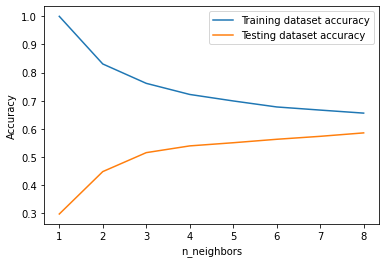

In [241]:
#https://www.geeksforgeeks.org/k-nearest-neighbor-algorithm-in-python/
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
print("Printing test accuracy for K Nearest Neighbour model on line", str(line))
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    
    train_accuracy[i] = knn.score(X_train, y_train) # should be as close to 0 as possible (percentage error)

    test_accuracy[i] = knn.score(X_test, y_test) # should be as close to 0 as possible (percentage error)

plt.plot(neighbors, train_accuracy, label = 'Training dataset accuracy')
plt.plot(neighbors, test_accuracy, label = 'Testing dataset accuracy')
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

In [242]:
print("Train score:", str(sum_train_score/len(lines_dir_1)))
print("Test score:", str(sum_test_score/len(lines_dir_1)))

Train score: 0.6670086369956052
Test score: 0.5738539763406357


In [243]:
print("Features currently in the dataframe:")
print(X_train.columns)

Features currently in the dataframe:
Index(['humidity', 'wind_speed', 'PLANNEDTIME_DEP', 'WEEKDAY', 'MONTH'], dtype='object')


**Improving the model**
- Initial test score is 0.566 with 8 features.
- Features will be dropped from the dataframe as per the previous modelling methods importance of features order.

**Step 1**
- Drop heavy_precip from the dataframe (now 7 features)
    - Mean test score is 0.566
- No improvement. Will try next feature.

**Step 2**
- Drop HOUR (now 6 features)
    - Mean test score is 0.574
- Improvement shown. Will drop next feature.

**Step 3**
- Drop weather_id (now 5 features)
    - Mean test score is 0.574
- No improvement. Will drop next feature.

**Step 4**
- Drop MONTH (now 4 features)
    - Mean test score is 0.574
- No improvement. Will return to Random Forest Regressor as predictive modelling method.


## Optimising the model

In [14]:
# setup dataframe
df_all = pd.get_dummies(df_dir_1[df_dir_1['LINEID'] == '46A'])
y = df_all["TRIPTIME"]
X = df_all.drop(["TRIPTIME"],1)

# initialised empty dataframe
RandomForest_Depth = pd.DataFrame()

# calculate cross val score incrementing max depth by 1 each iteration
# append results to dataframe
for i in range(1,11):
    df1 = cross_val_RandomForest_DF(X,y,i)
    df1.rename(columns={'Random_Forests':f'depth={i}'}, inplace=True)
    RandomForest_Depth = pd.concat([RandomForest_Depth, df1], axis=1)

# same calculation but use no max depth this time
#no_max_depth = cross_val_RandomForest_DF(X,y)
#no_max_depth.rename(columns={'Random_Forests':f'no_max_depth'}, inplace=True)
#RandomForest_Depth = pd.concat([RandomForest_Depth, no_max_depth], axis=1)
RandomForest_Depth

,depth=1,depth=2,depth=3,depth=4,depth=5,depth=6,depth=7,depth=8,depth=9,depth=10
accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Direction 2
Remembering from <i>feature_pairwise_interactions.ipynb</i> the following:
* categorical_med_info_gain = ['heavy_precip','weather_id']
* categorical_high_info_gain = ['HOUR','WEEKDAY','MONTH']

## Test-train-split

In [166]:
df_dir_2 = pd.read_csv('/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/modelling_ready_dir1.csv')

Began model creation for Direction 2 by dropping both 'heavy_precip' from the dataframe as this feature was dropped from direction 1's modelling.

In [167]:
df_dir_2 = df_dir_2.drop(columns=['heavy_precip','weather_id','HOUR','MONTH'])

In [168]:
lines_dir_2 = sorted(list(df_dir_2['LINEID'].unique()))
lines_dir_2

['1',
 '102',
 '104',
 '11',
 '111',
 '114',
 '116',
 '120',
 '122',
 '123',
 '13',
 '130',
 '14',
 '140',
 '142',
 '145',
 '14C',
 '15',
 '150',
 '151',
 '15A',
 '15B',
 '15D',
 '16',
 '161',
 '16C',
 '16D',
 '17',
 '17A',
 '18',
 '184',
 '185',
 '220',
 '236',
 '238',
 '239',
 '25',
 '25A',
 '25B',
 '25D',
 '25X',
 '26',
 '27',
 '270',
 '27A',
 '27B',
 '27X',
 '29A',
 '31',
 '31A',
 '31B',
 '31D',
 '32',
 '32X',
 '33',
 '33A',
 '33B',
 '33D',
 '33E',
 '33X',
 '37',
 '38',
 '38A',
 '38B',
 '38D',
 '39',
 '39A',
 '39X',
 '4',
 '40',
 '40B',
 '40D',
 '40E',
 '41',
 '41B',
 '41C',
 '41D',
 '41X',
 '42',
 '42D',
 '43',
 '44',
 '44B',
 '45A',
 '46A',
 '47',
 '49',
 '51D',
 '53',
 '54A',
 '56A',
 '59',
 '61',
 '63',
 '65',
 '65B',
 '66',
 '66A',
 '66B',
 '66X',
 '67',
 '67X',
 '68',
 '68A',
 '69',
 '69X',
 '7',
 '70',
 '70D',
 '75',
 '76',
 '76A',
 '77A',
 '79',
 '79A',
 '7A',
 '7B',
 '7D',
 '83',
 '83A',
 '84',
 '84A',
 '84X',
 '9']

Perform test-train-split

In [121]:
# Make dictionaries with keys for each stop with each train/test split value as its values.

X_train_dict_2 = {}
y_train_dict_2 = {}
X_test_dict_2 ={}
y_test_dict_2 = {}

for line in lines_dir_2:
    
    df_line = df_dir_2[df_dir_2['LINEID']==line]
    
    #check for df with low values
    if df_line.shape[0] < 3:
        print('Not enough values for line', str(line))
        lines_dir_2.remove(line)

    else:
        # randomly generate sequence based on dataframe index and set to be new index
        df_line.set_index(np.random.permutation(df_line.index))
        # sort the resulting random index
        df_line.sort_index(inplace=True)

        
        # drop unneeded columns
        df_line.drop(columns=['LINEID'], inplace=True)

        X = df_line.drop(["TRIPTIME"],1)
        y = pd.DataFrame(df_line['TRIPTIME'])

        # do test train split
        # Split the dataset into two datasets: 70% training and 30% test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

        X_train_dict_2[line] = X_train
        y_train_dict_2[line] = y_train
        X_test_dict_2[line] = X_test
        y_test_dict_2[line] = y_test
        
        # need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
        X_train.reset_index(drop=True, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        y_test.reset_index(drop=True, inplace=True)


Not enough values for line 41D


## Linear Regression

In [ ]:
model_dict_2 = {}

for line in lines_dir_2:
    print(f'Line {line}')
    
    X_train_dict_2[line] = X_train
    y_train_dict_2[line] = y_train
    X_test_dict_2[line] = X_test
    y_test_dict_2[line] = y_test

    linReg = LinearRegression().fit(X_train, y_train)
    
    model_dict_2[line] = linReg

    # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs

    dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/linearregression/picklefiles/line_{line}_model/dir2'
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)
    
    filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/linearregression/picklefiles/line_{line}_model/dir2/line_{line}_linreg.sav'
    pickle.dump(linReg, open(filename, 'wb'))

In [ ]:
for line in lines_dir_2:  

    # training data
    X_train = X_train_dict_2[line]
    y_train = y_train_dict_2[line]
    linReg = model_dict_2[line]
    
    # test data
    X_test = X_test_dict_2[line]
    y_test = y_test_dict_2[line]
    linReg = model_dict_2[line]
            
    print('Now modelling for line', str(line))
    
    linReg_predictions_train = list(linReg.predict(X_train))

    # train metrics
    train_mae = metrics.mean_absolute_error(y_train, linReg_predictions_train)
    train_mape = metrics.mean_absolute_percentage_error(y_train, linReg_predictions_train)
    train_mse = metrics.mean_squared_error(y_train, linReg_predictions_train)
    train_rmse = metrics.mean_squared_error(y_train, linReg_predictions_train)**(0.5)
    train_r2 = metrics.r2_score(y_train, linReg_predictions_train)

    linReg_predictions_test = list(linReg.predict(X_test))

    # test metrics
    test_mae = metrics.mean_absolute_error(y_test, linReg_predictions_test)
    test_mape = metrics.mean_absolute_percentage_error(y_test, linReg_predictions_test)
    test_mse = metrics.mean_squared_error(y_test, linReg_predictions_test)
    test_rmse = metrics.mean_squared_error(y_test, linReg_predictions_test)**(0.5)
    test_r2 = metrics.r2_score(y_test, linReg_predictions_test)
    
    with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/linearregression/picklefiles/line_{line}_model/dir2/line_{line}_linreg_metrics.csv', 'w') as file:
        file.write(f'\nTrain metrics for line {line}:'
                f'\nMAE: {metrics.mean_absolute_error(y_train, linReg_predictions_train)}' +\
                f'\nMAPE: {metrics.mean_absolute_percentage_error(y_train, linReg_predictions_train)}'+\
                f'\nMSE: {metrics.mean_squared_error(y_train, linReg_predictions_train)}'+\
                f'\nRMSE: {metrics.mean_squared_error(y_train, linReg_predictions_train)**(0.5)}'+\
                f'\nR2: {metrics.r2_score(y_train, linReg_predictions_train)}'+\
                f'\nTest metrics for line {line}:'
                f'\nMAE: {metrics.mean_absolute_error(y_test, linReg_predictions_test)}' +\
                f'\nMAPE: {metrics.mean_absolute_percentage_error(y_test, linReg_predictions_test)}'+\
                f'\nMSE: {metrics.mean_squared_error(y_test, linReg_predictions_test)}'+\
                f'\nRMSE: {metrics.mean_squared_error(y_test, linReg_predictions_test)**(0.5)}'+\
                f'\nR2: {metrics.r2_score(y_test, linReg_predictions_test)}')

## Random Forest Regressor

In [122]:
rf_model_dict_2 = {}

for line in lines_dir_2:
    print(f'Line {line}')
    
    X_train_dict_2[line] = X_train
    y_train_dict_2[line] = y_train
    X_test_dict_2[line] = X_test
    y_test_dict_2[line] = y_test

    rfr = RandomForestRegressor(n_estimators=50, max_features='auto', oob_score=True, random_state=1)
    result = rfr.fit(X_train, y_train)
    rf_model_dict_2[line] = rfr

    # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs

    dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/randomforest/picklefiles/line_{line}_model/dir2'
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)
    
    filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/randomforest/picklefiles/line_{line}_model/dir2/line_{line}_rfr.sav'
    pickle.dump(rfr, open(filename, 'wb'))

Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 118
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41A
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 46E
Line 47
Line 49
Line 51D
Line 51X
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 68X
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 7

In [123]:
# sum for averages
train_mae_sum = 0
train_mape_sum = 0
train_mse_sum = 0
train_r2_sum = 0

test_mae_sum = 0
test_mape_sum = 0
test_mse_sum = 0
test_r2_sum = 0

for line in lines_dir_2:  

    # training data
    X_train = X_train_dict_2[line]
    y_train = y_train_dict_2[line]
    rfr = rf_model_dict_2[line]
    
    # test data
    X_test = X_test_dict_2[line]
    y_test = y_test_dict_2[line]
    rfr = rf_model_dict_2[line]
            
    print('Now modelling for line', str(line))
    
    rfr_predictions_train = list(rfr.predict(X_train))
    rfr_predictions_test = list(rfr.predict(X_test))

    # choice of metrics from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56 and
    # https://towardsdatascience.com/random-forest-regression-5f605132d19d
    train_mae = metrics.mean_absolute_error(y_train, rfr_predictions_train) 
    train_mape = metrics.mean_absolute_percentage_error(y_train, rfr_predictions_train) # should be as close to 0 as possible (percentage error)
    train_mse = metrics.mean_squared_error(y_train, rfr_predictions_train) # as close to 0 as possible
    train_r2 = metrics.r2_score(y_train, rfr_predictions_train) #close to 1
    
    test_mae = metrics.mean_absolute_error(y_test, rfr_predictions_test) 
    test_mape = metrics.mean_absolute_percentage_error(y_test, rfr_predictions_test) 
    test_mse = metrics.mean_squared_error(y_test, rfr_predictions_test)
    test_r2 = metrics.r2_score(y_test, rfr_predictions_test)


    with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/data/modelling/randomforest/picklefiles/line_{line}_model/dir2/line_{line}_rfr_metrics.csv', 'w') as file:
        file.write(f'\nTrain metrics for line {line}:'
                f'\nMAE: {train_mae}'+\
                f'\nMAPE: {train_mape}'+\
                f'\nMSE: {train_mse}'+\
                f'\nR2: {train_r2}' +\
                f'\nTest metrics for line {line}:'
                f'\nMAE: {test_mae}'+\
                f'\nMAPE: {test_mape}'+\
                f'\nMSE: {test_mse}'+\
                f'\nR2: {test_r2}')

    # sum for averages
    train_mae_sum +=train_mae
    train_mape_sum +=train_mape
    train_mse_sum +=train_mse
    train_r2_sum +=train_r2

    test_mae_sum += test_mae
    test_mape_sum += test_mape
    test_mse_sum += test_mse
    test_r2_sum += test_r2
    

Now modelling for line 1
Now modelling for line 102
Now modelling for line 104
Now modelling for line 11
Now modelling for line 111
Now modelling for line 114
Now modelling for line 116
Now modelling for line 118
Now modelling for line 120
Now modelling for line 122
Now modelling for line 123
Now modelling for line 13
Now modelling for line 130
Now modelling for line 14
Now modelling for line 140
Now modelling for line 142
Now modelling for line 145
Now modelling for line 14C
Now modelling for line 15
Now modelling for line 150
Now modelling for line 151
Now modelling for line 15A
Now modelling for line 15B
Now modelling for line 15D
Now modelling for line 16
Now modelling for line 161
Now modelling for line 16C
Now modelling for line 17
Now modelling for line 17A
Now modelling for line 18
Now modelling for line 184
Now modelling for line 185
Now modelling for line 220
Now modelling for line 236
Now modelling for line 238
Now modelling for line 239
Now modelling for line 25
Now modelli

In [124]:
print("============Train metrics=============")
print("Mean MAE:", str(train_mae_sum/len(lines_dir_2)))
print("Mean MAPE:", str(train_mape_sum/len(lines_dir_2)))
print("Mean MSE:", str(train_mse_sum/len(lines_dir_2)))
print("Mean R2:", str(train_r2_sum/len(lines_dir_2)))

print("============Test metrics=============")
print("Mean MAE:", str(test_mae_sum/len(lines_dir_2)))
print("Mean MAPE:", str(test_mape_sum/len(lines_dir_2)))
print("Mean MSE:", str(test_mse_sum/len(lines_dir_2)))
print("Mean R2:", str(test_r2_sum/len(lines_dir_2)))

============Train metrics=============
Mean MAE: 142.59088763473886
Mean MAPE: 0.03148989851516051
Mean MSE: 38669.83917555216
Mean R2: 0.9512136212812548
============Test metrics=============
Mean MAE: 377.89608188812605
Mean MAPE: 0.08650742274456277
Mean MSE: 249017.51497062593
Mean R2: 0.7022152917722337


In [125]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfr.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
2,PLANNEDTIME_DEP,0.652812
3,WEEKDAY,0.129314
0,humidity,0.109030
1,wind_speed,0.108844


|FEATURE|IMPORTANCE|%|
|-------|----------|-|
|PLANNEDTIME_DEP|0.603|60.3%|
|WEEKDAY|0.118|11.8%
|wind_speed|0.074|7.4%|
|MONTH|0.064|6.4%|
|humidity|0.060|6.0%|
|HOUR|0.043|4.3%|
|weather_id|0.037|3.7%|

- The above result shows that PLANNEDTIME_DEP is the most influential on the model at 60%. This means that PLANNEDTIME_DEP accounts for 60% of the variation in TRIPTIME.

- Initial mean test MAE is 362.37 or 6 minutes 2 seconds
- Initial mean test MAPE is 0.0829 or 8.29%


**Improving the model**

**Step 1**
- Drop weather_id from the dataframe (3.7% importance at present with 7 features)
    - Mean test MAE now 357.46 or 5 minutes and 57 seconds
    - Mean test MAPE now 0.0819 or 8.19%
- MAE and MAPE have decreased showing that the model has improved.

**Step 2**
- Drop HOUR (4.5% importance at present with 6 features)
    - Mean test MAE now 356.73 or 5 minutes and 57 seconds
    - Mean test MAPE now 0.0817 or 8.17%
- MAE and MAPE have decreased showing that the model has improved.

**Step 3**
- Drop MONTH (7.2% importance at present with 5 features)
    - Mean test MAE now 377.9 or 6 minutes and 18 seconds
    - Mean test MAPE now 0.0865 or 8.65%
- MAE and MAPE have increased showing that the model has disimproved. We will revert back to the previous step, where the model contains the following five features:
    - PLANNEDTIME_DEP
    - WEEKDAY
    - wind_speed
    - MONTH
    - humidity